# Telecom Customer Behavior Analysis

# Overview

# Business Problem

# Data Understanding

The available data comes from a telecom compoany's record of customer information. In this analysis, I examine features that are likely to play a role in customer churn. They include:

- State
- Account Length (in months)
- Area Code
- International Plan (y/n)
- Voice Mail Plan (y/n)
- No. of Voicemail Messages
- Total Day Minutes, Calls, and Charges
- Total Evening Minutes, Calls, and Charges
- Total Night Minutes, Calls, and Charges
- Total International Minutes, Calls, and Charges
- No. of Customer Service Calls

# Data Analysis

## Preparation and EDA

Before we begin the iterative modeling process, we need to take a look at the data to better understand its structure features. We will check for outliers, visualize our target and some correlations, and build some pipelines to speed up preprocessing down the line.

In [2]:
# Importing relevant libraries
import pandas as pd
import numpy as np
import os
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, \
cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, \
StackingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, \
f1_score, plot_confusion_matrix, confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline

In [3]:
# Loading dataset
df = pd.read_csv('data/customer_churn_data.csv')

# Priting first 5 rows
df.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


All our data is nicely laid out for us. Right off the bat, I notice that our target column is currently categorical, so we will want to transform that into binary down the line. There is also definitely a large majority of numeric columns, with only a single truly categorical one (state).

The next step is to check for missing values, which I can do below:

In [4]:
# Printing dataframe information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   area code               3333 non-null   int64  
 3   phone number            3333 non-null   object 
 4   international plan      3333 non-null   object 
 5   voice mail plan         3333 non-null   object 
 6   number vmail messages   3333 non-null   int64  
 7   total day minutes       3333 non-null   float64
 8   total day calls         3333 non-null   int64  
 9   total day charge        3333 non-null   float64
 10  total eve minutes       3333 non-null   float64
 11  total eve calls         3333 non-null   int64  
 12  total eve charge        3333 non-null   float64
 13  total night minutes     3333 non-null   float64
 14  total night calls       3333 non-null   

No missing values! That's a plus. For preprocessing, we'll need to know which columns are numeric and which are categorical. For the categorica columns, we need to take a look and see what we're going to do with them.

It also appears that our target column ("churn") is a categorical boolean. We can change this to 1s and 0s by casting the whole column as an integer.

Customer phone numbers won't be too useful in this case, so we can drop that column. For two other categorical features (international plan and voice mail plan), we can also make those binary choices into 1s and 0s. That way, we don't have to bother one-hot encoding them later.

In [5]:
# Casting churn as an integer
df['churn'] = df['churn'].astype(int)

In [6]:
# Dropping phone number column
df = df.drop('phone number', axis=1)

In [7]:
# Replacing two string columns with integers
df[['international plan', 'voice mail plan']] = df[['international plan', 'voice mail plan']].replace(
    {'yes': 1, "no": 0})

Now that we've better organized our data, we can check out some correlation values.

<AxesSubplot:>

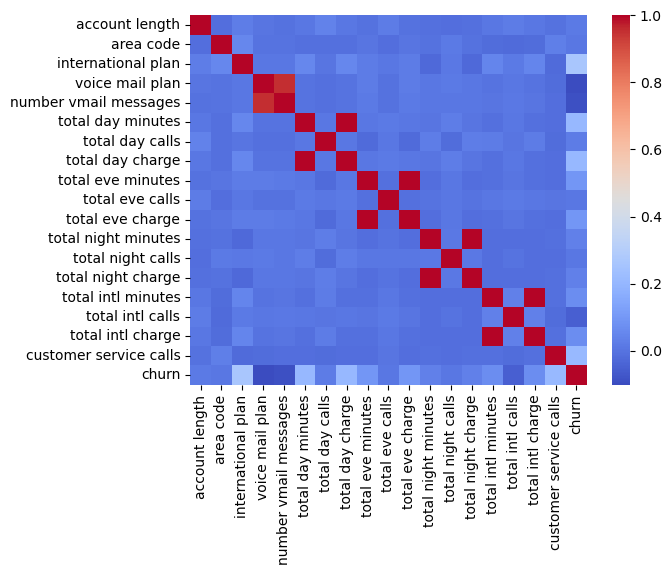

In [8]:
# Creating correlation heatmap
df_corrs = df.corr()
sns.heatmap(df_corrs, cmap='coolwarm')

This seems like a fairly normal correlation chart. We see that red diagonal streak, which is caused by identical variables correlating perfectly with each other. The red squares surrounding the streak is likely caused by strong correlations between calls, minutes, and charge for each time of day.

On the bottom row, you can see that certain features have slightly higher correlations with churn. The two that stand out to me are customer service calls and having an international plan. More customer service calls would make sense because those normally are a product of customer dissatisfaction. Having an international plan might lead to higher charges or more headache, so that could be another common cause for churn. We can take a closer look at the numerical value of these correlations below:

In [9]:
numeric_cols = df.drop('state', axis=1)
numeric_cols.corrwith(df['churn']).sort_values(ascending=False)

churn                     1.000000
international plan        0.259852
customer service calls    0.208750
total day minutes         0.205151
total day charge          0.205151
total eve minutes         0.092796
total eve charge          0.092786
total intl charge         0.068259
total intl minutes        0.068239
total night charge        0.035496
total night minutes       0.035493
total day calls           0.018459
account length            0.016541
total eve calls           0.009233
area code                 0.006174
total night calls         0.006141
total intl calls         -0.052844
number vmail messages    -0.089728
voice mail plan          -0.102148
dtype: float64

Indeed, an international plan and customer service calls are the two largest indicators of churn. Total day minutes and the associated charges are also correlated, indicating that perhaps some customers are switching providers for better value on their day minutes.

We can take a look at some key statistics for the entire dataset below:

In [10]:
df.describe()

,account length,area code,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,101.064806,437.182418,0.096910,0.276628,8.099010,179.775098,100.435644,30.562307,200.980348,100.114311,17.083540,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,1.562856,0.144914
std,39.822106,42.371290,0.295879,0.447398,13.688365,54.467389,20.069084,9.259435,50.713844,19.922625,4.310668,50.573847,19.568609,2.275873,2.791840,2.461214,0.753773,1.315491,0.352067
min,1.000000,408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,74.000000,408.000000,0.000000,0.000000,0.000000,143.700000,87.000000,24.430000,166.600000,87.000000,14.160000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000,0.000000
50%,101.000000,415.000000,0.000000,0.000000,0.000000,179.400000,101.000000,30.500000,201.400000,100.000000,17.120000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000,0.000000
75%,127.000000,510.000000,0.000000,1.000000,20.000000,216.400000,114.000000,36.790000,235.300000,114.000000,20.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,2.000000,0.000000
max,243.000000,510.000000,1.000000,1.000000,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000,1.000000


We can see that the average customer has been using this company as their provider for 101 months, which is just under eight and a half years. Of these customers, about 10% have an international plan.

# ADD MORE ABOVE??

In [11]:
df.head()

,state,account length,area code,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0
1,OH,107,415,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
2,NJ,137,415,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
3,OH,84,408,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
4,OK,75,415,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0


In [12]:
(df['churn'].value_counts()/3333) * 100

0    85.508551
1    14.491449
Name: churn, dtype: float64

It looks like we have a pretty large class imbalance within the target column. The negative case makes up 85.5% of the total cases in the dataset. This means that, if we made a model that only guessed the negative case every time, we would already wind up with 85.5% accuracy! That's no good. We can change this by resampling the data to make it more even. However, to avoid data leakage, let's first split the data into train and test sets. After that, we can set up some handy pipelines to preprocess our data before feeding it into some models.

In [13]:
y = df['churn']

X = df.drop('churn', axis=1)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [15]:
print((y_train.value_counts()/len(y_train)) * 100)

print((y_test.value_counts()/len(y_test)) * 100)

0    85.67427
1    14.32573
Name: churn, dtype: float64
0    85.01199
1    14.98801
Name: churn, dtype: float64


As we can see, the target ratios are still imbalanced after the split. Now, we can go about building some pipelines to rectify that!

In [16]:
numeric_pipe = Pipeline(steps=[('scaler', StandardScaler())])

categorical_pipe = Pipeline([('ohe', OneHotEncoder(sparse=True, handle_unknown='ignore'))])

In [17]:
preprocessing_pipe = ColumnTransformer(transformers=[
                                        ('numeric_pipe', numeric_pipe, 
                                         make_column_selector(dtype_include=['int', 'float'])), 
    
                                        ('categorical_pipe', categorical_pipe, 
                                         make_column_selector(dtype_include='object'))])

The column transformer above will work to preprocess our data for us. For rebalancing our target samples, we have to use a different pipeline, which we will create once we begin modeling.

# Preliminary Modeling

In [18]:
%load_ext autotime

time: 274 µs (started: 2024-02-24 18:08:24 -05:00)


## Logistic Regression

Now that we have our preprocessing pipeline, we can forego a lot of the manual preprocessing steps and just use our trusty pipelines! We're going to make a new pipeline here that incorporates a Synthetic Minority Over-sampling Technique, or SMOTE. This will balance out the target samples, making our model's results more significant. 

Note that, for logistic regressions, we are going to be scaling our data. For future models, we may not need to.

In [19]:
logreg_pipe = ImPipeline(steps=[('preprocessor', preprocessing_pipe),
                                   ('sm', SMOTE(random_state=42)),
                                   ('logreg', LogisticRegression(solver='liblinear', random_state=42))])

time: 895 µs (started: 2024-02-24 18:08:24 -05:00)


In [20]:
logreg_model = logreg_pipe.fit(X_train, y_train)
logreg_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric_pipe',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x17377a2e0>),
                                                 ('categorical_pipe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x17377acd0>)])),
                ('sm', SMOTE(random_state=42)),
                ('logreg',
                 LogisticRegression(random_state=42, solver='liblinear'))])

time: 64.2 ms (started: 2024-02-24 18:08:24 -05:00)


In [21]:
logreg_model.score(X_train, y_train)

0.7799119647859144

time: 10.3 ms (started: 2024-02-24 18:08:25 -05:00)


In [22]:
logreg_y_pred = logreg_model.predict(X_test)

time: 10.8 ms (started: 2024-02-24 18:08:25 -05:00)


In [27]:
print(classification_report(y_test, logreg_y_pred))

              precision    recall  f1-score   support

           0       0.95      0.77      0.85       709
           1       0.37      0.78      0.50       125

    accuracy                           0.77       834
   macro avg       0.66      0.77      0.68       834
weighted avg       0.86      0.77      0.80       834

time: 2.27 ms (started: 2024-02-23 17:16:09 -05:00)


## Decision Tree

In [72]:
dec_tree_preprocessor = ColumnTransformer(transformers=[
                                          ('ohe', OneHotEncoder(sparse=True, handle_unknown='ignore'), 
                                           [0])], remainder='passthrough')

time: 762 µs (started: 2024-02-24 10:11:28 -05:00)


In [79]:
dec_tree_pipe = ImPipeline(steps=[('ohe', dec_tree_preprocessor),
                                  ('sm', SMOTE(random_state=42)),
                                  ('tree', DecisionTreeClassifier(random_state=42))])

time: 1.42 ms (started: 2024-02-24 10:15:47 -05:00)


In [80]:
dec_tree_model = dec_tree_pipe.fit(X_train, y_train)
dec_tree_model

Pipeline(steps=[('ohe',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  [0])])),
                ('sm', SMOTE(random_state=42)),
                ('tree', DecisionTreeClassifier(random_state=42))])

time: 98.5 ms (started: 2024-02-24 10:16:26 -05:00)


In [83]:
dec_tree_model.score(X_train, y_train)

1.0

time: 15.7 ms (started: 2024-02-24 10:17:35 -05:00)


In [81]:
dec_tree_y_pred = dec_tree_model.predict(X_test)

time: 12.8 ms (started: 2024-02-24 10:17:12 -05:00)


In [82]:
print(classification_report(y_test, dec_tree_y_pred))

              precision    recall  f1-score   support

           0       0.96      0.93      0.94       709
           1       0.66      0.78      0.72       125

    accuracy                           0.91       834
   macro avg       0.81      0.86      0.83       834
weighted avg       0.92      0.91      0.91       834

time: 9.98 ms (started: 2024-02-24 10:17:13 -05:00)


## Random Forest

In [90]:
random_forest_pipe = ImPipeline(steps=[('ohe', dec_tree_preprocessor),
                                  ('sm', SMOTE(random_state=42)),
                                  ('tree', RandomForestClassifier(random_state=42))])

time: 922 µs (started: 2024-02-24 10:33:25 -05:00)


In [91]:
random_forest_model = random_forest_pipe.fit(X_train, y_train)

time: 590 ms (started: 2024-02-24 10:33:27 -05:00)


In [92]:
random_forest_model.score(X_train, y_train)

1.0

time: 49.4 ms (started: 2024-02-24 10:35:04 -05:00)


In [93]:
random_forest_y_pred = random_forest_model.predict(X_test)

time: 30 ms (started: 2024-02-24 10:35:26 -05:00)


In [94]:
print(classification_report(y_test, random_forest_y_pred))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       709
           1       0.83      0.70      0.76       125

    accuracy                           0.93       834
   macro avg       0.89      0.84      0.86       834
weighted avg       0.93      0.93      0.93       834

time: 7.36 ms (started: 2024-02-24 10:35:26 -05:00)


hello
time: 764 µs (started: 2024-02-24 12:19:05 -05:00)


# Final Model

## Tuning

## Evaluation

# Conclusions

## Next Steps

## Contact Information

In [59]:
Xtrain2, Xtest2, ytrain2, ytest2 = train_test_split(X, y, random_state=25)

time: 6.83 ms (started: 2024-02-24 10:01:00 -05:00)


(2499, 51)
<class 'pandas.core.frame.DataFrame'>


<2499x51 sparse matrix of type '<class 'numpy.float64'>'
	with 2499 stored elements in Compressed Sparse Row format>

time: 8.05 ms (started: 2024-02-24 10:06:13 -05:00)


In [71]:
Xtrain2_state_encoded_dense = Xtrain2_state_encoded.toarray()

# Convert the dense array to a DataFrame
Xtrain2_state_encoded_df = pd.DataFrame(Xtrain2_state_encoded_dense, columns=ohe.get_feature_names_out())

# Now you can use .head() to view the first few rows
Xtrain2_state_encoded_df.head()

,state_AK,state_AL,state_AR,state_AZ,state_CA,state_CO,state_CT,state_DC,state_DE,state_FL,...,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


time: 25 ms (started: 2024-02-24 10:08:10 -05:00)


In [63]:
print(Xtrain2['state'].nunique())

51
time: 1.69 ms (started: 2024-02-24 10:03:50 -05:00)


(2499, 51)
time: 624 µs (started: 2024-02-24 10:04:17 -05:00)
